## 📑 `AIDOVECL pipeline schematic`

coupe


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
Using cache found in /u/kazemi2/.cache/torch/hub/miccunifi_QualiCLIP_main


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

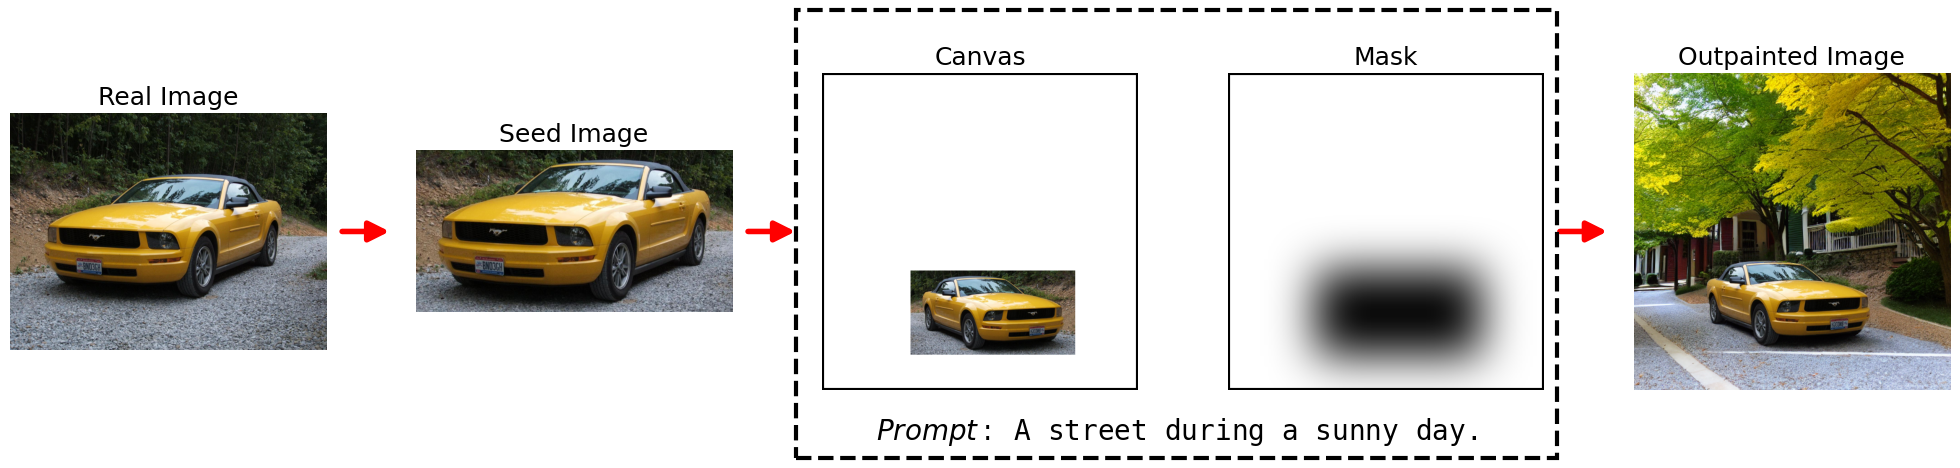

In [8]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from src import detect, outpaint, backdrop, utils

import yaml
with open('config/aidovecl-config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
base_path = "./figs/fig1"
prompt = "A street during a sunny day."

def setup_directories():
    for key in ["seed_unsplit", "seed", "real_unsplit", "real", "outpainted"]:
        full_path = os.path.join(base_path, key)
        if os.path.exists(full_path):
            shutil.rmtree(full_path)
        os.makedirs(full_path)

def generate_seed_images(real_raw_folder_name):
    real_path = os.path.join(base_path, real_raw_folder_name)
    seed_path = os.path.join(base_path, "seed_unsplit")
    for vehicle_type in os.listdir(real_path):
        input_folder = os.path.join(real_path, vehicle_type)
        output_folder = os.path.join(seed_path, vehicle_type)
        print(vehicle_type)
        detect.process_folder(input_folder, output_folder, config=config, retain_uncropped = True)

def split_dataset(folder_name, seed):
    folder_path = os.path.join(base_path, folder_name)
    folder_split_path = os.path.join(base_path, '_'.join(folder_name.split('_')[:-1]))
    splitter = utils.DatasetSplitter(folder_path, folder_split_path, split_ratios={'train': 1, 'val': 0, 'test': 0}, seed=seed)
    splitter.execute()
    shutil.rmtree(folder_path)

def perform_outpainting():
    seed_split_path = os.path.join(base_path, "seed")
    outpainted_path = os.path.join(base_path, "outpainted")
    outpaint.generate_outpainted(seed_split_path, outpainted_path, config=config, prompt=prompt, save_interim=True, random_seed=10)

def get_nth_image_file(directory, n=0):
    files = sorted([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if files and n < len(files):
        return Image.open(os.path.join(directory, files[n]))
    return None

def create_visualizations():
    plt.rcParams['font.size'] = 20         # Default font size
    plt.rcParams['axes.titlesize'] = 18    # Axes title font size
    plt.rcParams['axes.labelsize'] = 16    # X and Y axis label font size
    plt.rcParams['xtick.labelsize'] = 14   # X axis tick labels
    plt.rcParams['ytick.labelsize'] = 14   # Y axis tick labels
    plt.rcParams['legend.fontsize'] = 16   # Legend font size

    # Define directories
    dirs = {
        'real': os.path.join(base_path, 'real_raw', 'coupe'),
        'seed': os.path.join(base_path, 'seed', 'train', 'images'),
        'canvas': os.path.join(base_path, 'canvas', 'train', 'images'),
        'mask': os.path.join(base_path, 'mask', 'train', 'images'),
        'outpainted': os.path.join(base_path, 'outpainted', 'train', 'images')
    }

    # Load images
    images = {key: get_nth_image_file(path, 0) for key, path in dirs.items()}

    # Create figure and subplots
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    fig.subplots_adjust(wspace=0.05)  # Decrease the space between subplots

    titles = ['Real Image', 'Seed Image', 'Canvas', 'Mask', 'Outpainted Image']
    for ax, (title, key) in zip(axs, zip(titles, images.keys())):
        if images[key]:
            ax.imshow(images[key])
            ax.set_title(title)
            ax.axis('off')

        if key in ['canvas', 'mask']:
            # Highlight canvas and mask
            rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, linewidth=3, edgecolor='black', facecolor='none')
            ax.add_patch(rect)

    # Highlighting canvas and mask
    bbox_canvas = axs[2].get_position()
    bbox_mask = axs[3].get_position()
    x0 = min(bbox_canvas.x0, bbox_mask.x0) - 0.03
    y0 = min(bbox_canvas.y0, bbox_mask.y0) - 0.15
    x1 = max(bbox_canvas.x1, bbox_mask.x1) + 0.045
    y1 = max(bbox_canvas.y1, bbox_mask.y1) + 0.15
    rect_big = Rectangle((x0, y0), x1 - x0, y1 - y0, transform=fig.transFigure, linewidth=3, edgecolor='black', facecolor='none', linestyle='--')
    fig.patches.append(rect_big)
    fig.text((x0 + x1) / 2, y0 + 0.02, '$Prompt: $ ' + prompt, fontname='monospace', ha='center', va='bottom', color='black')

    # Add arrows between images, except between canvas and mask
    for i in range(4):
        if i != 2:  # Skip arrow between canvas and mask
            axs[i].annotate('', xy=(1.05, 0.5), xycoords='axes fraction', xytext=(1.2, 0.5),
                            arrowprops=dict(arrowstyle="<|-", lw=4, color='red', shrinkA=0, shrinkB=0, mutation_scale=30))

    plt.tight_layout()
    plt.savefig(os.path.join(base_path, "pipeline.pdf"), format="pdf", bbox_inches='tight', dpi=300)
    plt.show()


setup_directories()
generate_seed_images("real_raw")
split_dataset("real_unsplit", 0)
split_dataset("seed_unsplit", 0)
perform_outpainting()
create_visualizations()